# Evaluate results of conditional sampling with Hyformer

First, jointly fine-tune the model and sample with `scripts/conditional_sampling/generate.py`. 

In [1]:
# imports

import os
import torch

from hyformer.configs.dataset import DatasetConfig
from hyformer.utils.datasets.auto import AutoDataset

from hyformer.utils.runtime import set_seed

import pandas as pd
import numpy as np

/ictstr01/groups/aih/adam.izdebski/envs/hyformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with 

In [12]:
# constants

method = "joint"
target_name = "qed"
target_value = 0.7
seed = 1337

DATA_DIR = '/lustre/groups/aih/jointformer/icml25/data'
PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'

PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"


In [13]:
# Load dataset

dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')


Converting target to float32.


In [15]:
# load generated samples

path_to_generated_samples = get_path_to_generated_samples(METHOD, TARGET_NAME, SEED)
_df = pd.read_csv(path_to_generated_samples)
_df = _df[:100000]
_df["properties_normalized"] = train_dataset.target_transform(_df["properties"])

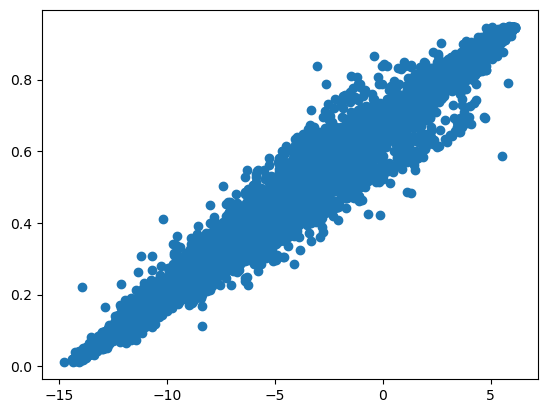

In [17]:
# plot predicted vs oracle values

import matplotlib.pyplot as plt

plt.scatter(_df['properties_normalized'], _df['oracle_values'])

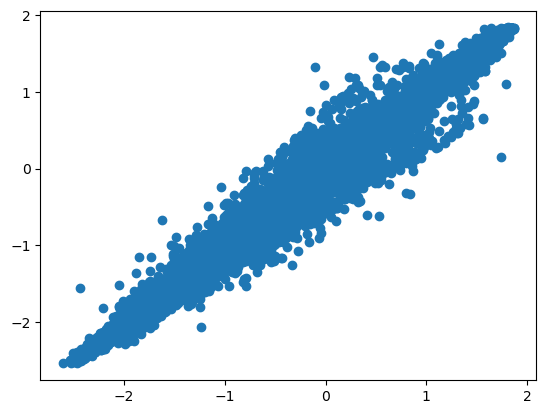

In [18]:
# scatterplot

import matplotlib.pyplot as plt

plt.scatter(_df['properties'], train_dataset.target_transform(_df['oracle_values']))
     

In [ ]:
### Joint sampling 


_epsilon = 0.001

_scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
     

# Filter out NaNs
oracle_values = oracle_values[~oracle_values.isna()]

# Sampled
print(f'Sampled {len(samples)} samples')

# Calculate metrics
print('---*---')
mad = np.mean(np.abs(oracle_values - target_value))
print(f'MAD (oracle space): {mad:.3f}')
std = np.std(oracle_values)
print(f'STD (oracle space): {std:.3f}')
# print('---*---')
# mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
# print(f'MAD (normalized space): {mad:.3f}')
# std = np.std(train_dataset.target_transform(oracle_values))
# print(f'STD (normalized space): {std:.3f}')
# print('---*---')
validity = sum(is_valid_sample) / len(is_valid_sample)
print(f'Validity: {validity:.3f}')

Sampled 45 samples
---*---
MAD (oracle space): 0.009
STD (oracle space): 0.015
Validity: 1.000


In [87]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "no_joint"
target_name = "qed"
_epsilon = 0.005

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.5, 0.7, 0.9]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')
    
    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []
    
    for seed in [1337, 1338, 1339]:
    
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for qed: 0.5 -> no_joint
MAD: 0.033 (0.001)
STD: 0.047 (0.002)
Validity: 0.993 (0.003)
Accepted samples numbers: 314.667 (6.799)
Acceptance rate: 0.003 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for qed: 0.7 -> no_joint
MAD: 0.031 (0.001)
STD: 0.045 (0.001)
Validity: 0.994 (0.003)
Accepted samples numbers: 367.333 (10.873)
Acceptance rate: 0.004 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for qed: 0.9 -> no_joint
MAD: 0.018 (0.001)
STD: 0.025 (0.004)
Validity: 0.994 (0.005)
Accepted samples n

In [88]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "joint"
target_name = "qed"
_epsilon = 0.005

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.5, 0.7, 0.9]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')
    
    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []
    
    for seed in [1337, 1338, 1339]:
        
        
    
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for qed: 0.5 -> joint
MAD: 0.010 (0.001)
STD: 0.018 (0.002)
Validity: 0.983 (0.009)
Accepted samples numbers: 295.000 (19.201)
Acceptance rate: 0.003 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for qed: 0.7 -> joint
MAD: 0.009 (0.000)
STD: 0.018 (0.002)
Validity: 0.990 (0.006)
Accepted samples numbers: 329.667 (4.028)
Acceptance rate: 0.003 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for qed: 0.9 -> joint
MAD: 0.006 (0.001)
STD: 0.010 (0.003)
Validity: 0.996 (0.005)
Accepted samples numbers: 1

In [89]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "no_joint"
target_name = "sa"
_epsilon = 0.005

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.7, 0.8, 0.9]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')

    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []

    for seed in [1337, 1338, 1339]:
    
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for sa: 0.7 -> no_joint
MAD: 0.020 (0.001)
STD: 0.027 (0.002)
Validity: 0.986 (0.009)
Accepted samples numbers: 144.333 (5.185)
Acceptance rate: 0.001 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for sa: 0.8 -> no_joint
MAD: 0.016 (0.000)
STD: 0.021 (0.000)
Validity: 0.985 (0.001)
Accepted samples numbers: 448.000 (14.697)
Acceptance rate: 0.004 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for sa: 0.9 -> no_joint
MAD: 0.009 (0.001)
STD: 0.012 (0.001)
Validity: 0.999 (0.002)
Accepted samples numb

In [90]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "joint"
target_name = "sa"
_epsilon = 0.005

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.7, 0.8, 0.9]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')
    
    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []
    
    for seed in [1337, 1338, 1339]:
        
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for sa: 0.7 -> joint
MAD: 0.008 (0.001)
STD: 0.015 (0.003)
Validity: 0.976 (0.005)
Accepted samples numbers: 140.333 (9.741)
Acceptance rate: 0.001 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for sa: 0.8 -> joint
MAD: 0.005 (0.000)
STD: 0.009 (0.002)
Validity: 0.981 (0.002)
Accepted samples numbers: 426.000 (12.832)
Acceptance rate: 0.004 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for sa: 0.9 -> joint
MAD: 0.001 (0.000)
STD: 0.004 (0.000)
Validity: 0.999 (0.002)
Accepted samples numbers: 254.

In [97]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "no_joint"
target_name = "logp"
_epsilon = 0.001

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.0, 2.0, 4.0]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')
    
    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []
    
    for seed in [1337, 1338, 1339]:
        
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for logp: 0.0 -> no_joint
MAD: 0.131 (0.012)
STD: 0.162 (0.015)
Validity: 0.978 (0.031)
Accepted samples numbers: 13.667 (3.399)
Acceptance rate: 0.000 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for logp: 2.0 -> no_joint
MAD: 0.135 (0.007)
STD: 0.174 (0.010)
Validity: 0.983 (0.004)
Accepted samples numbers: 75.667 (7.040)
Acceptance rate: 0.001 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for logp: 4.0 -> no_joint
MAD: 0.127 (0.011)
STD: 0.175 (0.016)
Validity: 0.995 (0.007)
Accepted samples n

In [96]:
mads_across_seeds = []
stds_across_seeds = []
validities_across_seeds = []
accepted_samples_numbers_across_seeds = []
acceptance_rates_across_seeds = []

method = "joint"
target_name = "logp"
_epsilon = 0.001

PATH_TO_DATASET_CONFIG   = f'configs/datasets/guacamol/{target_name}/config.json'
dataset_config = DatasetConfig.from_config_file(PATH_TO_DATASET_CONFIG)
train_dataset = AutoDataset.from_config(dataset_config, root=DATA_DIR, split='train')

for target_value in [0.0, 2.0, 4.0]:
    print('-'*100)
    print(f'Target value for {target_name}: {target_value} -> {method}')
    
    validities = []
    mads = []
    stds = []
    accepted_samples_numbers = []
    acceptance_rates = []
    
    for seed in [1337, 1338, 1339]:
    
        PATH_TO_GENERATED_SAMPLES = f"/lustre/groups/aih/adam.izdebski/hyformer/results/conditional_sampling/{method}/{target_name}/seed_{seed}/generated_samples_{target_name}.csv"
        _df = pd.read_csv(PATH_TO_GENERATED_SAMPLES)
        _df = _df[:100000]
        
        ### Joint sampling 

        _scores = np.abs(np.array(_df['properties']) - train_dataset.target_transform(target_value))
        samples = _df.loc[_scores < _epsilon, 'smiles'].tolist()
        oracle_values = _df.loc[_scores < _epsilon, 'oracle_values']
        is_valid_sample = _df.loc[_scores < _epsilon, 'is_valid_smiles']
        acceptance_rate = len(samples) / len(_df)

        # Filter out NaNs
        oracle_values = oracle_values[~oracle_values.isna()]

        # Sampled
        # print(f'Sampled {len(samples)} samples')

        # Calculate metrics
        # print('---*---')
        mad = np.mean(np.abs(oracle_values - target_value))
        # print(f'MAD (oracle space): {mad:.3f}')
        std = np.std(oracle_values)
        # print(f'STD (oracle space): {std:.3f}')
        # print('---*---')
        # mad = np.mean(np.abs(train_dataset.target_transform(oracle_values) - train_dataset.target_transform(TARGET_VALUE)))
        # print(f'MAD (normalized space): {mad:.3f}')
        # std = np.std(train_dataset.target_transform(oracle_values))
        # print(f'STD (normalized space): {std:.3f}')
        # print('---*---')
        validity = sum(is_valid_sample) / len(is_valid_sample)
        # print(f'Validity: {validity:.3f}')
        acceptance_rates.append(acceptance_rate)
        
        validities.append(validity)
        mads.append(mad)
        stds.append(std)
        acceptance_rates.append(acceptance_rate)
        accepted_samples_numbers.append(len(samples))

        mads_across_seeds.append(mads)
        stds_across_seeds.append(stds)
        validities_across_seeds.append(validities)
        accepted_samples_numbers_across_seeds.append(accepted_samples_numbers)
        acceptance_rates_across_seeds.append(acceptance_rates)

    print(f'MAD: {np.mean(mads):.3f} ({np.std(mads):.3f})')
    print(f'STD: {np.mean(stds):.3f} ({np.std(stds):.3f})')
    print(f'Validity: {np.mean(validities):.3f} ({np.std(validities):.3f})')
    print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers):.3f} ({np.std(accepted_samples_numbers):.3f})')
    print(f'Acceptance rate: {np.mean(acceptance_rates):.3f} ({np.std(acceptance_rates):.3f})')
    print('-'*100)
    
print('-'*100)
print(f'{method} {target_name}')
print(f'MAD: {np.mean(mads_across_seeds):.3f} ({np.std(mads_across_seeds):.3f})')
print(f'STD: {np.mean(stds_across_seeds):.3f} ({np.std(stds_across_seeds):.3f})')
print(f'Validity: {np.mean(validities_across_seeds):.3f} ({np.std(validities_across_seeds):.3f})')
print(f'Accepted samples numbers: {np.mean(accepted_samples_numbers_across_seeds):.3f} ({np.std(accepted_samples_numbers_across_seeds):.3f})')
print(f'Acceptance rate: {np.mean(acceptance_rates_across_seeds):.3f} ({np.std(acceptance_rates_across_seeds):.3f})')
print('-'*100)


Converting target to float32.
----------------------------------------------------------------------------------------------------
Target value for logp: 0.0 -> joint
MAD: 0.033 (0.005)
STD: 0.037 (0.007)
Validity: 1.000 (0.000)
Accepted samples numbers: 11.000 (3.559)
Acceptance rate: 0.000 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for logp: 2.0 -> joint
MAD: 0.044 (0.001)
STD: 0.057 (0.003)
Validity: 0.991 (0.007)
Accepted samples numbers: 70.000 (7.118)
Acceptance rate: 0.001 (0.000)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Target value for logp: 4.0 -> joint
MAD: 0.046 (0.001)
STD: 0.059 (0.001)
Validity: 0.971 (0.011)
Accepted samples numbers: 6